### I. Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

### II. Page de doc

In [2]:
# Dataset hosted on Hugging Face to centralize the project workflow
XLSX_URL = "https://huggingface.co/datasets/flodussart/getaround_xls_certif/resolve/main/get_around_delay_analysis.xlsx"

doc = pd.read_excel(XLSX_URL, sheet_name=1)
display(doc)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,Flow used for both checkin and checkout. (ie. ...
3,state,canceled means that the rental did not happen ...
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end t...
5,previous_ended_rental_id,id of the previous ended rental of the car (NU...
6,time_delta_with_previous_rental_in_minutes,Difference in minutes between this rental plan...


Dictionnaire des variables — Delay Analysis - Documentation fournie en annexe

| Nom du champ                           | Description |
|----------------------------------------|-------------|
|`rental_id`                       | Identifiant unique de la location |
| `car_id`                             | Identifiant unique de la voiture |
| `checkin_type`                      | Mode d’accès et de retour du véhicule : <br> - *mobile* : contrat signé sur le smartphone du propriétaire <br> - *connect* : voiture équipée de la technologie Connect (ouverture via le smartphone du conducteur) <br> Les contrats papier sont exclus (peu utilisés et pas de données de retard disponibles). |
| `state`                              | État de la location. <br> - *canceled* : la location n’a pas eu lieu (annulée par le conducteur ou le propriétaire). |
| `delay_at_checkout_in_minutes`       | Différence (en minutes) entre l’heure de fin prévue et l’heure effective de retour du véhicule. <br> - Valeurs *positives* : retard <br> - Valeurs *négatives* : retour anticipé |
| `previous_ended_rental_id`           | Identifiant de la location précédente de la même voiture (NULL si aucune location précédente ou si l’écart est supérieur à 12 heures). |
| `time_delta_with_previous_rental_in_minutes` | Différence (en minutes) entre l’heure de début planifiée de cette location et l’heure de fin planifiée de la précédente (si l’écart est inférieur à 12 heures, sinon NULL). |


### III. EDA 

#### A. Statistiques descriptives

In [3]:
df = pd.read_excel(XLSX_URL, sheet_name=0)
df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [5]:
# Basic stats
print("Number of rows : {}".format(df.shape[0]))
print()

print("Display of dataset: ")
display(df.head())
print()

print("Basics statistics: ")
data_desc = df.describe(include="all")
print(data_desc)

print("Percentage of missing values: ")
display(100 * df.isnull().sum() / df.shape[0])

Number of rows : 21310

Display of dataset: 


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN



Basics statistics: 
            rental_id         car_id checkin_type  state  \
count    21310.000000   21310.000000        21310  21310   
unique            NaN            NaN            2      2   
top               NaN            NaN       mobile  ended   
freq              NaN            NaN        17003  18045   
mean    549712.880338  350030.603426          NaN    NaN   
std      13863.446964   58206.249765          NaN    NaN   
min     504806.000000  159250.000000          NaN    NaN   
25%     540613.250000  317639.000000          NaN    NaN   
50%     550350.000000  368717.000000          NaN    NaN   
75%     560468.500000  394928.000000          NaN    NaN   
max     576401.000000  417675.000000          NaN    NaN   

        delay_at_checkout_in_minutes  previous_ended_rental_id  \
count                   16346.000000               1841.000000   
unique                           NaN                       NaN   
top                              NaN                       N

rental_id                                      0.000000
car_id                                         0.000000
checkin_type                                   0.000000
state                                          0.000000
delay_at_checkout_in_minutes                  23.294228
previous_ended_rental_id                      91.360863
time_delta_with_previous_rental_in_minutes    91.360863
dtype: float64

<div style="font-size: 0.85em;">
<h4 align="center">Analyse descriptive</h4>

#### A. Typologie des variables

- Identifiants techniques : `rental_id`, `car_id`, `previous_ended_rental_id`
- Variables catégorielles : type de check-in (`mobile`, `connect`), état de la location
- Variables numériques clés :
  - retard au checkout (minutes)
  - temps entre deux locations successives (buffer)


#### B. Stat

- Le retard au checkout est fortement asymétrique, avec une majorité de locations proches de la ponctualité.
- Quelques retards extrêmes (plusieurs jours) biaisent les statistiques classiques.
- Le temps entre deux locations successives est centré autour de quelques heures, et constitue une variable clé pour évaluer le risque de conflit.


#### C. Valeurs manquantes

- Le retard au checkout comporte ~23 % de valeurs manquantes (locations annulées ou non terminées).
- Les variables liées à la location précédente sont majoritairement manquantes par construction et ne traduisent pas un problème de qualité des données.


> Conclusion :  
> Seule la variable retard (delay_at_checkout_in_minutes) présente de vraies valeurs manquantes nécessitant un traitement spécifique.
> La variable gap (time_delta_with_previous_rental_in_minutes) n’est renseignée que lorsqu’une location précédente existe — elle est donc analysée uniquement dans ces cas.


#### D. Insights préliminaires

- La majorité des locations sont rendues à l’heure, mais quelques retards extrêmes nécessitent une approche robuste.
- Le délai entre deux locations est un facteur déterminant pour limiter les conflits de planning.
- Le mode de check-in semble influencer la ponctualité et mérite une analyse approfondie.
</div>


#### B. Distribution des variables catégorielles

##### 1. Types de check-in

In [4]:
df["checkin_type"].value_counts()

checkin_type
mobile     17003
connect     4307
Name: count, dtype: int64

In [5]:
checkin_counts = (
    df["checkin_type"]
    .value_counts()
    .rename_axis("Type de check-in")
    .reset_index(name="Nombre de locations")
)

display(checkin_counts)

fig1 = px.bar(
    checkin_counts,
    x="Type de check-in",
    y="Nombre de locations",
    text_auto=True,
    color="Type de check-in",
    title="Nombre de locations par type de check-in"
)

fig1.update_layout(title_x=0.5, plot_bgcolor="white")

fig1.show()

# Number of distinct cars by check-in type
car_counts = (
    df.groupby("checkin_type")["car_id"]
    .nunique()
    .reset_index(name="Nombre de voitures distinctes")
)

display(car_counts)

fig2 = px.bar(
    car_counts,
    x="checkin_type",
    y="Nombre de voitures distinctes",
    text_auto=True,
    color="checkin_type",
    title="Nombre de voitures distinctes par type de check-in"
)

fig2.update_layout(title_x=0.5, plot_bgcolor="white")

fig2.show()


,Type de check-in,Nombre de locations
0,mobile,17003
1,connect,4307


,checkin_type,Nombre de voitures distinctes
0,connect,714
1,mobile,7525


In [6]:
# Car used with more than one check-in type
car_modes = df.groupby("car_id")["checkin_type"].nunique()

cars_hybrides = (car_modes > 1).sum()
cars_uniques = car_modes.size

print(f"Voitures hybrides (utilisées dans les deux modes) : {cars_hybrides}")
print(f"Voitures totales uniques : {cars_uniques}")

Voitures hybrides (utilisées dans les deux modes) : 96
Voitures totales uniques : 8143


In [7]:
# Distribution of check-in types (%)
checkin_counts_counts = df["checkin_type"].value_counts(normalize=True) * 100
checkin_counts_counts

checkin_type
mobile     79.788832
connect    20.211168
Name: proportion, dtype: float64

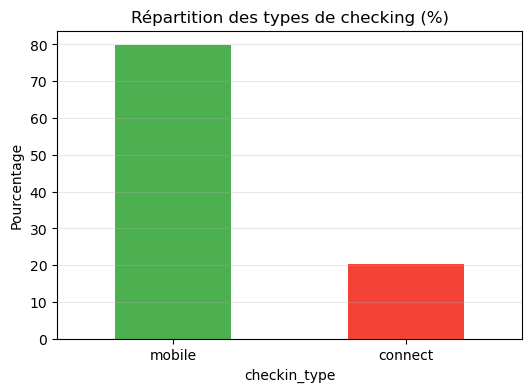

In [8]:
checkin_counts_counts.plot(
    kind="bar",
    figsize=(6, 4),
    color=["#4CAF50", "#F44336"]
)

plt.title("Répartition des types de checking (%)")
plt.ylabel("Pourcentage")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

<div style="font-size: 0.85em;">
La grande majorité des locations (≈80 %) utilisent le check-in mobile, contre seulement 20 % via la technologie Connect.
</div>

##### 2. Statuts de location

In [9]:
df["state"].value_counts()

state
ended       18045
canceled     3265
Name: count, dtype: int64

In [10]:
# Share of each state
state_counts = df["state"].value_counts(normalize=True) * 100
state_counts

state
ended       84.678555
canceled    15.321445
Name: proportion, dtype: float64

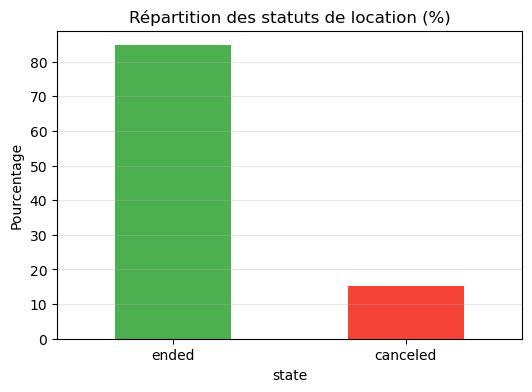

In [11]:
state_counts.plot(
    kind="bar",
    figsize=(6, 4),
    color=["#4CAF50", "#F44336"]
)

plt.title("Répartition des statuts de location (%)")
plt.ylabel("Pourcentage")
plt.xticks(rotation=0)
plt.grid(axis="y", alpha=0.3)
plt.show()

<div style="font-size: 0.85em;">
La majorité des locations (≈85 %) se sont déroulées jusqu’au bout, tandis qu’environ 15 % ont été annulées.
</div>

##### 3. Répartition des statuts de location selon le type de check-in

In [12]:
# Rental status distribution by check-in type
table = df.groupby("checkin_type")["state"].value_counts(normalize=True).unstack()
table

state,canceled,ended
checkin_type,,
connect,0.185280,0.814720
mobile,0.145092,0.854908


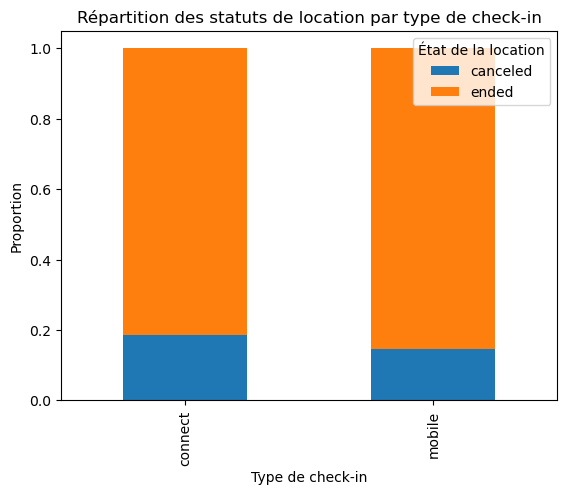

In [13]:
table.plot(kind="bar", stacked=True)
plt.title("Répartition des statuts de location par type de check-in")
plt.ylabel("Proportion")
plt.xlabel("Type de check-in")
plt.legend(title="État de la location")
plt.show()

In [14]:
# Rental status share by check-in type (cancellation vs ended)
counts = df.groupby(["checkin_type", "state"]).size().reset_index(name="count")

# Convert counts to within check-in type proportions
table = (
    counts.pivot(index="checkin_type", columns="state", values="count")
    .fillna(0)  
    .pipe(lambda x: x.div(x.sum(axis=1), axis=0))
    .reset_index()
)

# Long format for Plotly
df_long = table.melt(  
    id_vars="checkin_type",
    var_name="État de la location",
    value_name="Proportion"
)

color_map_duo = {
    "ended": "#4cc9f0",
    "canceled": "#ffb703"
}

fig = px.bar(
    df_long,
    x="checkin_type",
    y="Proportion",
    color="État de la location",
    color_discrete_map=color_map_duo,
    text=df_long["Proportion"].apply(lambda x: f"{x * 100:.1f}%"),
    barmode="stack",
    title="Taux d’annulation selon le mode de check-in"
)

fig.update_layout(
    title=dict(x=0.5, xanchor="center", font=dict(size=16, color="black")),
    xaxis_title="Type de check-in",
    yaxis_title="Proportion",
    legend_title="État de la location",
    plot_bgcolor="white",
    yaxis=dict(tickformat=".0%", range=[0, 1]),
    bargap=0.3
)

fig.update_traces(
    textposition="inside",
    insidetextanchor="middle",
    textfont_size=12
)

fig.show()

In [15]:
# Create a crosstab
crosstab = pd.crosstab(df["checkin_type"], df["state"])

# chi² Test
chi2, p, dof, expected = stats.chi2_contingency(crosstab)
print(f"p-value = {p}")

p-value = 7.178108006896458e-11


In [16]:
n = crosstab.values.sum()
cramers_v = np.sqrt(chi2 / (n * (min(crosstab.shape) - 1)))
print(f"Cramér's V = {cramers_v:.3f}")

Cramér's V = 0.045


<div style="font-size: 0.85em;">

- Les locations via Connect présentent un taux d’annulation légèrement plus élevé (≈18.5 %) que celles via Mobile (≈14.5 %).
- Le test du χ² confirme que cette différence est statistiquement significative (p < 0.001).
- L’effet reste très faible (Cramér’s V = 0.045), indiquant que l’impact opérationnel de ce facteur est limité malgré l’existence d’un lien statistique.
</div>

#### C. Distribution des variables numériques 

##### 1. Répartition du nombre de location par véhicule

In [17]:
duplicates_rental = df[df.duplicated(subset="rental_id", keep=False)]

if duplicates_rental.empty:
    print("Aucun doublon trouvé pour rental_id.")
else:
    print(f" {duplicates_rental['rental_id'].nunique()} rental_id en doublon détectés")
    print(f"Nombre total de lignes concernées : {len(duplicates_rental)}")
    display(duplicates_rental.sort_values("rental_id").head(10))

Aucun doublon trouvé pour rental_id.


In [18]:
# Compute number of rentals per car
rentals_per_car = df.groupby("car_id")["rental_id"].count().reset_index()
rentals_per_car.columns = ["car_id", "nb_rentals"]

# Bar chart: Exact number of cars per rental count
rental_distribution = (
    rentals_per_car["nb_rentals"].value_counts().sort_index().reset_index()
)
rental_distribution.columns = ["nb_rentals", "nb_cars"]

fig = px.bar(
    rental_distribution,
    x="nb_rentals",
    y="nb_cars",
    text="nb_cars",
    title="<b>Distribution du nombre de location par véhicule</b>",
    labels={"nb_rentals": "Nombre de locations", "nb_cars": "Nombre de voitures"}
)
fig.update_traces(textposition="outside")
fig.update_layout(title_x=0.5) 
fig.show()

# Boxplot: Distribution with median and outliers
fig2 = px.box(
    rentals_per_car,
    y="nb_rentals",
    title="<b>Boxplot du nombre de locations par voiture</b>",
    labels={"nb_rentals": "Nombre de locations"}
)
fig2.update_layout(title_x=0.5)
fig2.show()

<div style="font-size:0.85rem">

#### Analyse des locations par véhicule
- La distribution des locations est fortement concentrée sur les faibles valeurs : la médiane est de 2 locations et la majorité des véhicules comptent moins de 5 locations.
- Le boxplot et l’histogramme mettent en évidence une distribution asymétrique, avec quelques cas extrêmes très rares dépassant 15 à 20 locations. 
- Ces valeurs extrêmes traduisent un déséquilibre d’utilisation au sein de la flotte.
</div>

##### 2. Répartition des restitutions

In [19]:
df["delay_at_checkout_in_minutes"].describe()

count    16346.000000
mean        59.701517
std       1002.561635
min     -22433.000000
25%        -36.000000
50%          9.000000
75%         67.000000
max      71084.000000
Name: delay_at_checkout_in_minutes, dtype: float64

In [20]:
# Delay distribution: zoomed view + extreme values (ended rentals only)
ZOOM_MIN, ZOOM_MAX = -500, 500

df_ended = df[df["state"].eq("ended")].copy()
delay = df_ended["delay_at_checkout_in_minutes"]

missing_count = int(delay.isna().sum())
total_ended = int(len(df_ended))

observed = delay.dropna()
core = observed[observed.between(ZOOM_MIN, ZOOM_MAX)]
outliers = observed[~observed.between(ZOOM_MIN, ZOOM_MAX)]

fig = make_subplots(
    rows=2, cols=1,
    vertical_spacing=0.25,
    row_heights=[0.75, 0.25],
    subplot_titles=(
        f"Boxplot des retards (zoom {ZOOM_MIN} à {ZOOM_MAX} min)",
        f"Valeurs extrêmes (|x| > {ZOOM_MAX} min) — n={len(outliers):,} "
        f"({len(outliers)/len(observed):.1%} des retards observés)"
    )
)

fig.add_trace(go.Box(x=core, boxpoints=False, name="Zoom"), row=1, col=1)
fig.add_trace(
    go.Scattergl(
        x=outliers, y=np.zeros(len(outliers)),
        mode="markers",
        marker=dict(size=3, opacity=0.45),
        name="Outliers"
    ),
    row=2, col=1
)

fig.update_yaxes(showticklabels=False, row=2, col=1)
fig.update_xaxes(title_text="Retard (minutes)", row=2, col=1)

fig.add_vline(x=0, line_dash="dash", opacity=0.6, row=1, col=1)
fig.add_vline(x=0, line_dash="dash", opacity=0.6, row=2, col=1)

fig.update_layout(
    height=560,
    showlegend=False,
    plot_bgcolor="white",
    title=dict(text="Retards de restitution — zoom et valeurs extrêmes", x=0.5)
)

fig.add_annotation(
    x=0.01, y=-0.12, xref="paper", yref="paper",
    text=f"Retard non renseigné parmi les 'ended' : {missing_count:,}/{total_ended:,} "
         f"({missing_count/total_ended*100:.1f} %)",
    showarrow=False, align="left"
)

fig.show()


<div style="font-size:0.85em">

#### Interprétation et choix méthodologiques

Environ 6,4 % des retards observés dépassent l’intervalle [-500, +500] minutes, traduisant probablement des anomalies de saisie ou des cas particuliers (ex. pannes, erreurs techniques).
Parmi les locations effectivement terminées (state="ended"), 9,4 % ne disposent pas de mesure de retard enregistrée au moment de l’extraction — ces cas sont représentés comme « Non renseigné » dans l’analyse des retards.

Choix retenu : conserver l’intégralité des données pour préserver la transparence analytique.
Un bornage d’analyse contrôlé ([-500, +1000] minutes) a simplement été appliqué afin de limiter l’impact visuel des valeurs extrêmes.
Toute suppression aurait nécessité une validation des équipes Getaround pour distinguer les anomalies techniques des cas opérationnels réels.

</div>

In [21]:
# 708 rentals exhibit extreme checkout delay values
df_ended[
    (df_ended["delay_at_checkout_in_minutes"] < -500)
    | (df_ended["delay_at_checkout_in_minutes"] > 1000)
].shape

(708, 7)

In [22]:
def classify_delay(x):
    if pd.isna(x):
        return "non renseigné"
    if x < 0:
        return "en avance"
    if x == 0:
        return "à l'heure"
    return "en retard"

df_ended["return_status"] = df_ended["delay_at_checkout_in_minutes"].apply(classify_delay)

order = ["en avance", "à l'heure", "en retard", "non renseigné"]
df_ended["return_status"] = pd.Categorical(df_ended["return_status"], categories=order, ordered=True)

counts = df_ended["return_status"].value_counts(dropna=False).reindex(order)
props = (counts / counts.sum() * 100).round(1)
plot_df = pd.DataFrame({"statut": counts.index, "n": counts.values, "pct": props.values})

color_map = {
    "en avance": "#2ca02c",
    "à l'heure": "#9aa0a6",
    "en retard": "#d62728",
    "non renseigné": "#7f7f7f"
}


fig = px.pie(
    plot_df,
    values="pct",
    names="statut",
    title="Répartition des retours (avance / à l'heure / retard / manquant)",
    hole=0.5,
    color="statut",
    color_discrete_map=color_map
)

fig.update_traces(
    textinfo="percent+label",
    hovertemplate="<b>%{label}</b><br>%{value:.1f}%<br>n = %{customdata}",
    customdata=plot_df["n"]
)
fig.update_layout(title_x=0.5)
fig.show()

fig_bar = px.bar(
    plot_df,
    x="pct",
    y="statut",
    orientation="h",
    text="pct",
    color="statut",
    color_discrete_map=color_map,
    title="Proportions des statuts de retour",
    labels={"pct": "Pourcentage (%)", "statut": ""}
)
fig_bar.update_traces(texttemplate="%{text:.1f}%", textposition="outside")
fig_bar.update_layout(
    title_x=0.5, yaxis_categoryorder="array", yaxis_categoryarray=order
)

fig_bar.show()

<div style="font-size: 0.85em;">

#### Analyse de la répartition des retours
La visualisation met en évidence la distribution des statuts de retour des véhicules :  
- En retard : 52% des cas, ce qui constitue la proportion la plus importante.  
- En avance : 38 %, représentant près d’un tiers des retours.  
- Manquants : 9,4%, qui correspondent aux véhicules au statut de location annulé ou des données non renseignées. 
- À l’heure : seulement 0,7 %, ce qui est marginal.  

Ces résultats soulignent une forte tendance aux retards ou aux retours anticipés, tandis que les retours strictement à l’heure sont extrêmement rares.  
</div>


##### 3. Analyse des valeurs manquantes (retards non renseignés)

In [23]:
pd.crosstab(
    df["state"], df["delay_at_checkout_in_minutes"].isna(), normalize="index"
) * 100

delay_at_checkout_in_minutes,False,True
state,,
canceled,0.030628,99.969372
ended,90.579108,9.420892


In [24]:
df["delay_missing"] = df["delay_at_checkout_in_minutes"].isna()

In [25]:
# Compute the proportion of missing values by rental state
missing_by_state = df.groupby("state")["delay_missing"].mean().mul(100).reset_index()

In [27]:
# Share of missing checkout delay values by rental status
missing_by_state["n_missing"] = (
    df.groupby("state")["delay_at_checkout_in_minutes"]
    .apply(lambda x: x.isna().sum())
    .values
)

fig = px.bar(
    missing_by_state,
    x="state", 
    y="delay_missing",  
    text="delay_missing",  
    color="state", 
    title="Part des valeurs manquantes de délai selon le statut de location",
    labels={
        "delay_missing": "Proportion de valeurs manquantes (%)",
        "state": "Statut de location"
    },
    hover_data={
        "n_missing": True,
        "delay_missing": True
    }
)

fig.update_traces(
    texttemplate="%{text:.1f}%", 
    textposition="outside", 
    hovertemplate=(
        "<b>%{x}</b><br>"  
        "%{y:.1f}% manquants<br>" 
        "n = %{customdata[0]}" 
    )
)

fig.update_layout(
    yaxis=dict(range=[0, 110]),  
    title_x=0.5,  
    showlegend=False
)

fig.show()

<div style="font-size:0.85em;">
Les valeurs manquantes du délai sont systématiques pour les locations annulées (100 %) et marginales pour les locations terminées (9,4 %), ce qui confirme la cohérence du champ delay_at_checkout_in_minutes.
</div>

##### 4. Répartition des retours selon le type de check-in

In [28]:
# Keep rentals with an observed checkout delay only
df_delays = df.loc[
    df["delay_at_checkout_in_minutes"].notna(),
    ["checkin_type", "delay_at_checkout_in_minutes"]
].copy()

# Classify checkout timing: early / on-time / late
conds = [
    df_delays["delay_at_checkout_in_minutes"] > 0,
    df_delays["delay_at_checkout_in_minutes"] == 0,
    df_delays["delay_at_checkout_in_minutes"] < 0
]
df_delays["checkout_status"] = pd.cut(
    df_delays["delay_at_checkout_in_minutes"],
    bins=[-np.inf, -1e-9, 1e-9, np.inf],
    labels=["En avance", "À l'heure", "En retard"]
)

# Enforce a consistent category order for plotting
order_status = ["En avance", "À l'heure", "En retard"]
df_delays["checkout_status"] = pd.Categorical(
    df_delays["checkout_status"], categories=order_status, ordered=True
)

# Aggregate counts and compute within-type proportions
counts = (
    df_delays.groupby(["checkin_type", "checkout_status"], observed=True)
    .size()
    .reset_index(name="count")
)
counts["total_type"] = counts.groupby("checkin_type")["count"].transform("sum")
counts["pct"] = counts["count"] / counts["total_type"] * 100

# Grouped bar chart: checkout status by check-in type
fig = px.bar(
    counts,
    x="checkout_status",
    y="pct",
    color="checkin_type",
    barmode="group",
    text="pct",
    category_orders={"checkout_status": order_status},
    color_discrete_map={"mobile": "#1f77b4", "connect": "#ff7f0e"},
    labels={
        "checkout_status": "Checkout status",
        "pct": "Share (%)",
        "checkin_type": "Check-in type"
    },
    title="Checkout status distribution by check-in type"
)

fig.update_traces(
    texttemplate="%{text:.1f}%",
    textposition="outside",
    hovertemplate=(
        "<b>%{x}</b><br>"
        "Type: %{customdata[0]}<br>"
        "n = %{customdata[1]} / %{customdata[2]}<br>"
        "Share: %{y:.1f}%"
    ),
    customdata=np.stack(
        [counts["checkin_type"], counts["count"], counts["total_type"]], axis=-1
    )
)

fig.update_layout(title_x=0.5, yaxis_range=[0, 100])
fig.show()

In [29]:
n_total = len(df)
n_with_delay = df["delay_at_checkout_in_minutes"].notna().sum()
n_without_delay = df["delay_at_checkout_in_minutes"].isna().sum()

print("Total lignes :", n_total)
print("Avec délai observé :", n_with_delay)
print("Sans délai observé :", n_without_delay)
print("Check total :", n_with_delay + n_without_delay == n_total)

print("\nRépartition par state vs présence de délai :")
display(
    pd.crosstab(
        df["state"], df["delay_at_checkout_in_minutes"].notna(), margins=True
    ).rename(columns={True: "avec_délai", False: "sans_délai"})
)

print("\nRépartition par checkin_type vs présence de délai :")
display(
    pd.crosstab(
        df["checkin_type"], df["delay_at_checkout_in_minutes"].notna(), margins=True
    ).rename(columns={True: "avec_délai", False: "sans_délai"})
)

Total lignes : 21310
Avec délai observé : 16346
Sans délai observé : 4964
Check total : True

Répartition par state vs présence de délai :


delay_at_checkout_in_minutes,sans_délai,avec_délai,All
state,,,
canceled,3264,1,3265
ended,1700,16345,18045
All,4964,16346,21310



Répartition par checkin_type vs présence de délai :


delay_at_checkout_in_minutes,sans_délai,avec_délai,All
checkin_type,,,
connect,905,3402,4307
mobile,4059,12944,17003
All,4964,16346,21310


##### 5. Analyse des retours anticipés et tardifs


- Test méthodologique : utilisation de l’IQR pour explorer les bornes naturelles des retards.
- Les résultats servent de référence mais ne sont pas appliqués au filtrage réel des données.

In [31]:
col_delay = "delay_at_checkout_in_minutes"

def iqr_bounds(s):
    q1, q3 = s.quantile([0.25, 0.75])
    iqr = q3 - q1
    return q1 - 1.5 * iqr, q3 + 1.5 * iqr

early_s = df_ended.loc[df_ended[col_delay] < 0, col_delay].dropna()
late_s  = df_ended.loc[df_ended[col_delay] > 0, col_delay].dropna()

lb_early, _ = iqr_bounds(early_s)
_, ub_late  = iqr_bounds(late_s)

summary = pd.DataFrame({
    "segment": ["early (<0)", "late (>0)"],
    "n": [len(early_s), len(late_s)],
    "iqr_bound": [lb_early, ub_late],
    "n_outliers": [(early_s < lb_early).sum(), (late_s > ub_late).sum()]
})
summary["pct_outliers"] = (summary["n_outliers"] / summary["n"] * 100).round(2)

display(summary)

,segment,n,iqr_bound,n_outliers,pct_outliers
0,early (<0),6819,-271.5,699,10.25
1,late (>0),9404,299.0,1052,11.19


IQR lower bound (early returns): -271.5 min
IQR upper bound (late returns) : 299.0 min

Early returns (values < 0):
  Total observations        : 6819
  Inliers (within IQR)      : 6120 (89.75 %)
  Outliers (outside IQR)    : 699 (10.25 %)

Late returns (values > 0):
  Total observations        : 9404
  Inliers (within IQR)      : 8352 (88.81 %)
  Outliers (outside IQR)    : 1052 (11.19 %)



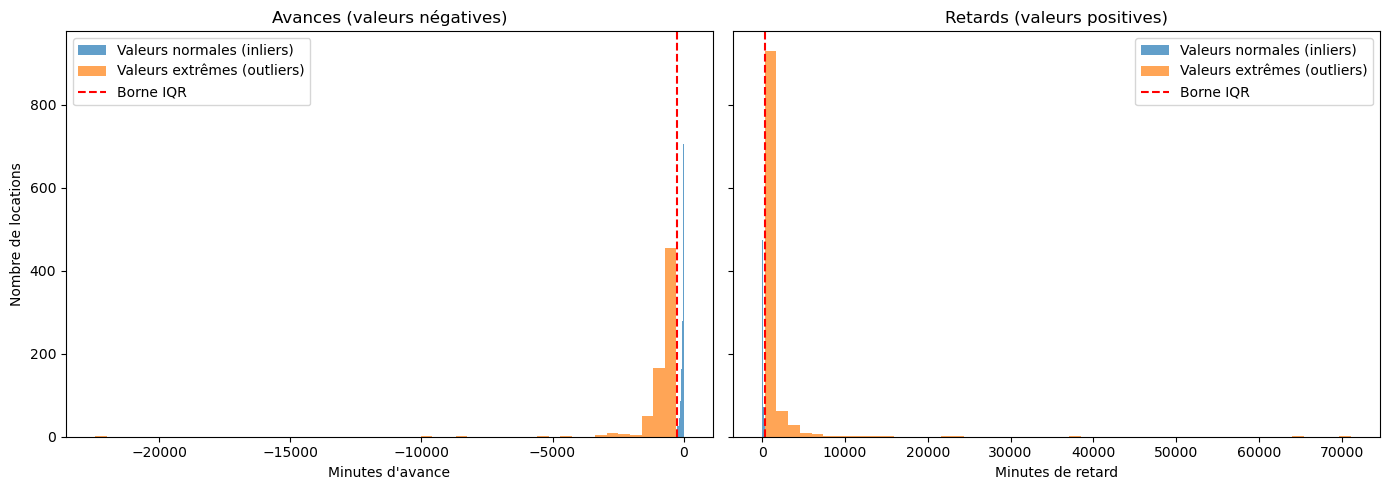

In [32]:
# Late returns (values > 0): compute IQR-based upper bound
positive_delays = df_ended.loc[df_ended[col_delay] > 0, col_delay].dropna()
q1_pos = positive_delays.quantile(0.25)
q3_pos = positive_delays.quantile(0.75)
iqr_pos = q3_pos - q1_pos
upper_bound_pos = q3_pos + 1.5 * iqr_pos

# Early returns (values < 0): compute IQR-based lower bound
negative_delays = df_ended.loc[df_ended[col_delay] < 0, col_delay].dropna()
q1_neg = negative_delays.quantile(0.25)
q3_neg = negative_delays.quantile(0.75)
iqr_neg = q3_neg - q1_neg
lower_bound_neg = q1_neg - 1.5 * iqr_neg

print(f"IQR lower bound (early returns): {lower_bound_neg:.1f} min")
print(f"IQR upper bound (late returns) : {upper_bound_pos:.1f} min\n")

# Separate inliers and outliers for both sides

# Early returns (negative values)
early = df_ended.loc[df_ended[col_delay] < 0, [col_delay]].dropna().copy()
early["is_outlier"] = early[col_delay] < lower_bound_neg

n_early = len(early)
n_early_out = int(early["is_outlier"].sum())
n_early_in = n_early - n_early_out

# Late returns (positive values)
late = df_ended.loc[df_ended[col_delay] > 0, [col_delay]].dropna().copy()
late["is_outlier"] = late[col_delay] > upper_bound_pos

n_late = len(late)
n_late_out = int(late["is_outlier"].sum())
n_late_in = n_late - n_late_out

print("Early returns (values < 0):")
print(f"  Total observations        : {n_early}")
print(
    f"  Inliers (within IQR)      : {n_early_in} ({n_early_in / n_early * 100:.2f} %)"
)
print(
    f"  Outliers (outside IQR)    : {n_early_out} ({n_early_out / n_early * 100:.2f} %)\n"
)

print("Late returns (values > 0):")
print(f"  Total observations        : {n_late}")
print(f"  Inliers (within IQR)      : {n_late_in} ({n_late_in / n_late * 100:.2f} %)")
print(
    f"  Outliers (outside IQR)    : {n_late_out} ({n_late_out / n_late * 100:.2f} %)\n"
)

# Two histograms: early / late returns, with outliers highlighted

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# Histogram for early returns
axes[0].hist(
    early.loc[~early["is_outlier"], col_delay],
    bins=50,
    alpha=0.7,
    label="Valeurs normales (inliers)"
)
axes[0].hist(
    early.loc[early["is_outlier"], col_delay],
    bins=50,
    alpha=0.7,
    label="Valeurs extrêmes (outliers)"
)
axes[0].axvline(lower_bound_neg, color="red", linestyle="--", label="Borne IQR")
axes[0].set_title("Avances (valeurs négatives)")
axes[0].set_xlabel("Minutes d'avance")
axes[0].set_ylabel("Nombre de locations")
axes[0].legend()

# Histogram for late returns
axes[1].hist(
    late.loc[~late["is_outlier"], col_delay],
    bins=50,
    alpha=0.7,
    label="Valeurs normales (inliers)"
)
axes[1].hist(
    late.loc[late["is_outlier"], col_delay],
    bins=50,
    alpha=0.7,
    label="Valeurs extrêmes (outliers)"
)
axes[1].axvline(upper_bound_pos, color="red", linestyle="--", label="Borne IQR")
axes[1].set_title("Retards (valeurs positives)")
axes[1].set_xlabel("Minutes de retard")
axes[1].legend()

plt.tight_layout()
plt.show()

<div style="font-size:0.85em;">
La durée exacte des locations n’est pas disponible dans le dataset fourni.
Néanmoins, l’analyse du délai entre deux locations successives montre que seules 8,9 % d’entre elles sont enchaînées dans les 12 heures.
Cela suggère que la majorité des locations ne sont pas relouées immédiatement et peuvent s’étaler sur plusieurs jours, conformément à la description du service Getaround.

En conséquence, les valeurs de retard importantes (jusqu’à plusieurs heures) demeurent plausibles, ce qui justifie le bornage analytique large [-500, +1000] minutes plutôt qu’un bornage statistique basé sur l’IQR.
</div>

- Analyse des retours anticipés

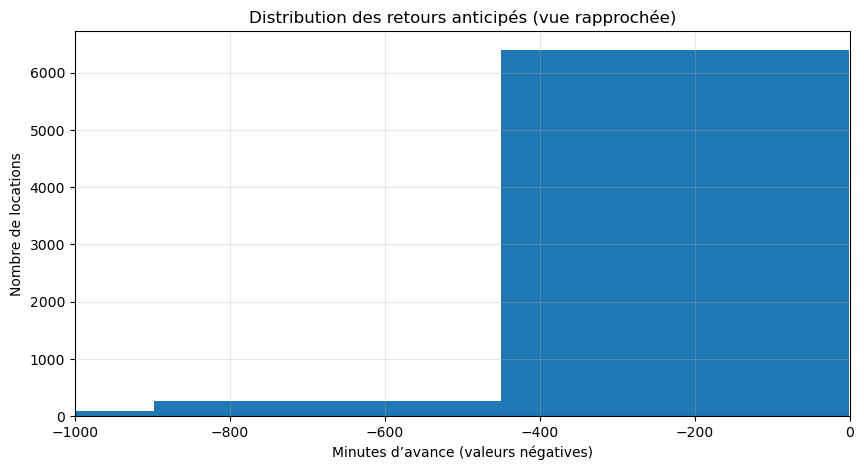

In [33]:
# Histogram (zoom) of early returns only
plt.figure(figsize=(10, 5))
negative_delays.hist(bins=50)
plt.title("Distribution des retours anticipés (vue rapprochée)")
plt.xlabel("Minutes d’avance (valeurs négatives)")
plt.ylabel("Nombre de locations")
plt.xlim(-1000, 0)  
plt.grid(True, alpha=0.3)
plt.show()

Distribution des retours anticipés par intervalle (en nombre) :
delay_at_checkout_in_minutes
< -2000            26
[-2000,-1000)      83
[-1000,-600)      202
[-600,-400)       162
[-400,-300)       146
[-300,-200)       321
[-200,-100)      1090
[-100,0)         4789
Name: count, dtype: int64


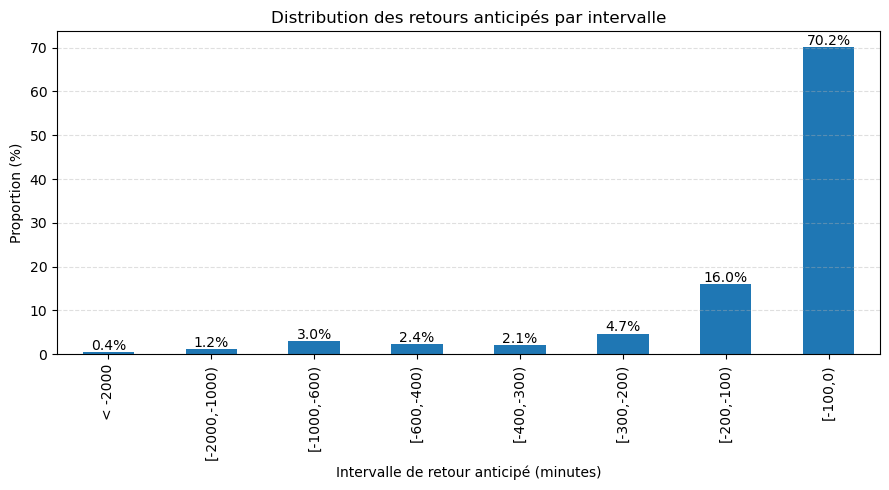

In [36]:
# Bucket early returns into intervals (cover full tail with -inf)
bins_early = [-np.inf, -2000, -1000, -600, -400, -300, -200, -100, 0]
labels_early = [
    "< -2000",
    "[-2000,-1000)",
    "[-1000,-600)",
    "[-600,-400)",
    "[-400,-300)",
    "[-300,-200)",
    "[-200,-100)",
    "[-100,0)"
]

early_cats = pd.cut(
    negative_delays, 
    bins=bins_early, 
    labels=labels_early, 
    right=False, 
    include_lowest=True
)

counts = early_cats.value_counts().sort_index()
perc = (counts / counts.sum() * 100).round(1)

print("Distribution des retours anticipés par intervalle (en nombre) :")
print(counts)

plt.figure(figsize=(9, 5))
perc.plot(kind="bar")
plt.xlabel("Intervalle de retour anticipé (minutes)")
plt.ylabel("Proportion (%)")
plt.title("Distribution des retours anticipés par intervalle")
for i, v in enumerate(perc.values):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

<div style="font-size:0.85em;">

- La majorité des retours anticipés se concentrent dans l’intervalle [-100, 0] minutes, qui représente 70 % des cas.
- On observe ensuite une proportion non négligeable (16%) dans l'intervalle [-200, -100].

=> Cela suggère que les retours anticipés sont généralement modérés, souvent limités à quelques heures avant l’heure prévue.
</div>

- Analyse des retards

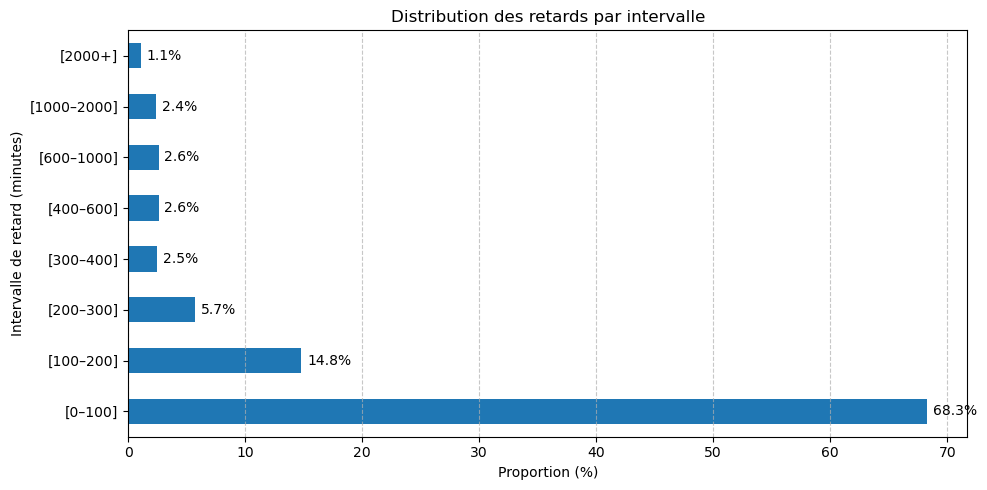

In [37]:
# Define delay intervals (in minutes)
bins_delay = [0, 100, 200, 300, 400, 600, 1000, 2000, np.inf]
labels_delay = [
    "[0–100]",
    "[100–200]",
    "[200–300]",
    "[300–400]",
    "[400–600]",
    "[600–1000]",
    "[1000–2000]",
    "[2000+]"
]

# Categorize positive delays into intervals
delay_cats = pd.cut(
    positive_delays, 
    bins=bins_delay, 
    labels=labels_delay, 
    right=True, 
    include_lowest=True
)

# Compute proportions per interval
delay_counts = delay_cats.value_counts().sort_index()
delay_pct = (delay_counts / delay_counts.sum() * 100).round(1)

# Plot distribution
ax = delay_pct.plot(kind="barh", figsize=(10, 5))
ax.set_xlabel("Proportion (%)")
ax.set_ylabel("Intervalle de retard (minutes)")
ax.set_title("Distribution des retards par intervalle")

# Add percentages annotations
for i, v in enumerate(delay_pct.values):
    ax.text(v + 0.5, i, f"{v:.1f}%", va="center")

ax.grid(axis="x", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

In [35]:
# Identify extreme delays and early returns
extreme_late = df_ended[df_ended["delay_at_checkout_in_minutes"] > upper_bound_pos]
extreme_early = df_ended[df_ended["delay_at_checkout_in_minutes"] < lower_bound_neg]

print(f"Retards extrêmes (> borne sup.) : {len(extreme_late)}")
print(f"Avances extrêmes (< borne inf.) : {len(extreme_early)}")
print(f"Total hors bornes : {len(extreme_late) + len(extreme_early)}")

Retards extrêmes (> borne sup.) : 1052
Avances extrêmes (< borne inf.) : 699
Total hors bornes : 1751


<div style="font-size:0.85em;">
La majorité des retards observés se situent dans des intervalles courts :
- 68 % des retards sont inférieurs à 100 minutes.
- 15 % se trouvent entre 100 et 200 minutes.

Les retards supérieurs à 200 minutes deviennent progressivement plus rares (moins de 6 % chacun par intervalle).

Cette distribution montre que les retards importants existent mais restent marginaux, la grande majorité des locations présentant un retard limité (< 200 minutes).
</div>

- Analyse des retours extrêmes (à l'avance et en retard)

In [ ]:
# Helper functions
def ensure_return_status(df, col="delay_at_checkout_in_minutes"):
    """Ensure 'return_status' exists: early (<0), on time (==0), late (>0)."""
    if "return_status" not in df.columns:
        df = df.copy()
        df["return_status"] = np.select(
            [df[col] < 0, df[col] == 0, df[col] > 0],
            ["en avance", "à l'heure", "en retard"],
            default="inconnu"
        )
    return df


def show_extremes(df, col, n=5, title="Aperçu"):
    """Display top-N extremes using nsmallest/nlargest."""
    wanted = ["rental_id", "car_id", "checkin_type", "state", col, "return_status"]
    keep = [c for c in wanted if c in df.columns]
    df = ensure_return_status(df, col)[keep]

    print(f"\n— {title} —")
    print(f"Colonnes affichées: {', '.join(keep)}")

    negatives = df[df[col] < 0].nsmallest(n, col)
    positives = df[df[col] > 0].nlargest(n, col)
    display(negatives)
    display(positives)

In [41]:
# Identify extreme values using previously computed bounds
extreme_late_returns = df_ended[
    df_ended["delay_at_checkout_in_minutes"] > upper_bound_pos
]
extreme_early_returns = df_ended[
    df_ended["delay_at_checkout_in_minutes"] < lower_bound_neg
]

# Combine early and late extremes for a global view
extremes_all = pd.concat(
    [extreme_early_returns, extreme_late_returns], ignore_index=True
)

# Display summary of extreme cases
show_extremes(
    extremes_all,
    col="delay_at_checkout_in_minutes",
    n=5,
    title="Cas extrêmes (retours anticipés et retards) – Top 5"
)


— Cas extrêmes (retours anticipés et retards) – Top 5 —
Colonnes affichées: rental_id, car_id, checkin_type, state, delay_at_checkout_in_minutes, return_status


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,return_status
264,526054,402173,mobile,ended,-22433.0,en avance
593,544471,361461,mobile,ended,-9849.0,en avance
559,556636,386498,mobile,ended,-8650.0,en avance
344,538720,371773,mobile,ended,-5475.0,en avance
148,528845,385378,mobile,ended,-4624.0,en avance


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,return_status
743,532240,379042,mobile,ended,71084.0,en retard
792,549980,402829,mobile,ended,64059.0,en retard
1388,537546,408750,mobile,ended,37382.0,en retard
747,534699,270195,mobile,ended,23126.0,en retard
976,556557,413591,mobile,ended,22618.0,en retard


##### 6. Analyse des délais entre deux locations successives

In [42]:
print(df_ended["time_delta_with_previous_rental_in_minutes"].describe())
print(
    "\nNbr of null values :",
    df_ended["time_delta_with_previous_rental_in_minutes"].isna().sum()
)

count    1612.000000
mean      277.071960
std       255.157331
min         0.000000
25%        60.000000
50%       180.000000
75%       540.000000
max       720.000000
Name: time_delta_with_previous_rental_in_minutes, dtype: float64

Nbr of null values : 16433


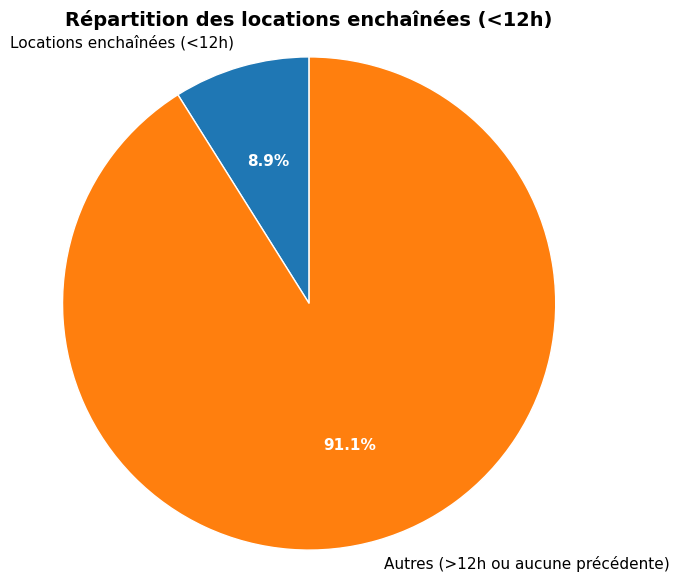

In [43]:
# Total number of completed rentals
total = len(df_ended)

# Rentals with a non-null time delta (< 12h defined in dataset)
with_delta = df_ended["time_delta_with_previous_rental_in_minutes"].notna().sum()

labels = ["Locations enchaînées (<12h)", "Autres (>12h ou aucune précédente)"]
sizes = [with_delta, total - with_delta]

# Pie chart
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(
    sizes,
    labels=labels,
    autopct="%1.1f%%",
    startangle=90,
    textprops={"fontsize": 11},
    wedgeprops={"edgecolor": "white"}
)

# Improve percentages readability
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")

plt.title("Répartition des locations enchaînées (<12h)", fontsize=14, weight="bold")
plt.axis("equal")
plt.show()

<div style="font-size: 0.85em;"> 
Sur les 18 045 locations terminées (`ended`), seules 1 612 disposent d’un délai renseigné entre la fin d’une location et le début de la suivante
→ soit 8,9 % des cas exploitables    
<br/>

#### Statistiques principales (sur les délais renseignés)

| Statistique | Valeur |
|-----------|--------|
| Moyenne | 277 minutes (~4h40) |
| Médiane | 180 minutes (3h) |
| 25 % des véhicules | < 60 minutes |
| 75 % des véhicules | < 540 minutes (~9h) |
| Maximum observé | 720 minutes (12h) |

Lorsque deux locations s’enchaînent sur le même véhicule, l’intervalle restant est souvent court, créant un risque de chevauchement en cas de retard.

#### Implication métier

> Un buffer trop court avant la location suivante peut entraîner un risque de chevauchement, si le conducteur restitue en retard.

Ce constat justifie l’analyse ultérieure de l’impact d’un retard sur la location suivante
</div>

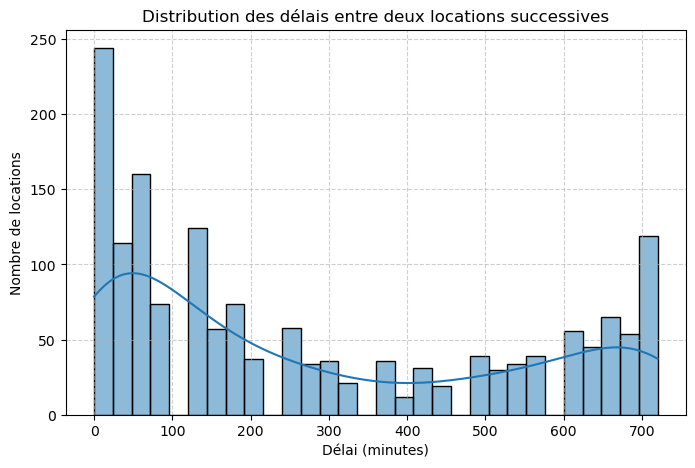

In [44]:
plt.figure(figsize=(8, 5))
sns.histplot(
    df_ended["time_delta_with_previous_rental_in_minutes"].dropna(), bins=30, kde=True
)
plt.title("Distribution des délais entre deux locations successives")
plt.xlabel("Délai (minutes)")
plt.ylabel("Nombre de locations")
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

<div style="font-size:0.85em">

#### Analyse de la distribution des délais entre deux locations successives
- On observe une forte concentration des délais entre <b>0 et 100 minutes</b>, ce qui traduit des locations enchaînées très rapidement.  
- Un pic marqué apparaît à <b>720 minutes (12 heures)</b>, probablement lié à une règle de planification ou une contrainte opérationnelle.  
- Entre ces deux extrêmes, la fréquence des délais diminue progressivement.  

Les véhicules sont donc soit reloués quasi immédiatement, soit remis en service après un délai standard de 12 heures.
</div>


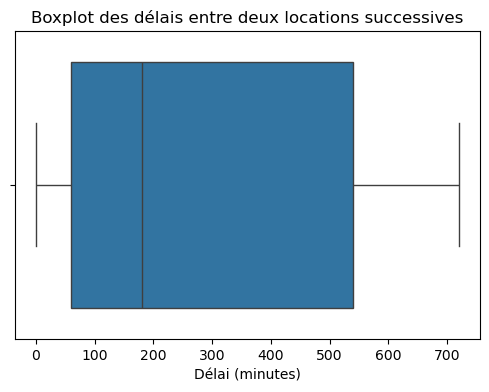

In [45]:
plt.figure(figsize=(6, 4))
sns.boxplot(x=df_ended["time_delta_with_previous_rental_in_minutes"].dropna())
plt.title("Boxplot des délais entre deux locations successives")
plt.xlabel("Délai (minutes)")
plt.show()

In [46]:
# Proportions of closely spaced rentals (with a previous rental)
thresholds = [60, 120, 180]

# Number of rentals with a previous rental 
total = df_ended["time_delta_with_previous_rental_in_minutes"].notna().sum()

for s in thresholds:
    count = (df_ended["time_delta_with_previous_rental_in_minutes"] < s).sum()
    pct = count / total * 100
    print(f"Rentals less than {s} min apart: {count} ({pct:.1f}%)")

Rentals less than 60 min apart: 358 (22.2%)
Rentals less than 120 min apart: 592 (36.7%)
Rentals less than 180 min apart: 773 (48.0%)


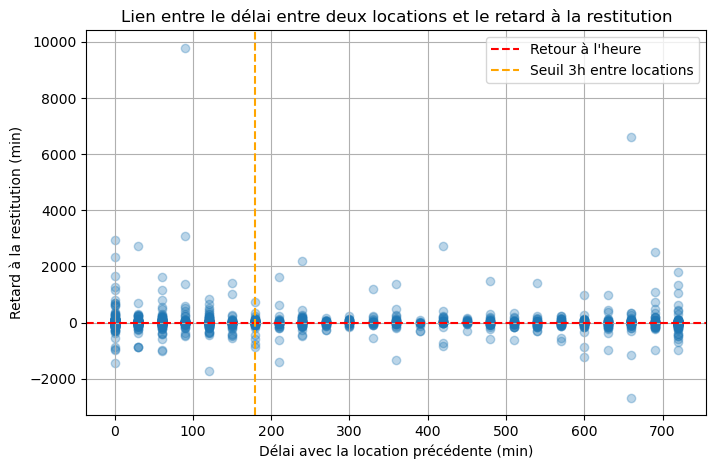

In [47]:
# Relationship between inter-rental time gap and retrurn delay
filtered = df_ended[
    df_ended["delay_at_checkout_in_minutes"].notna()
    & df_ended["time_delta_with_previous_rental_in_minutes"].notna()
]

plt.figure(figsize=(8, 5))
plt.scatter(
    filtered["time_delta_with_previous_rental_in_minutes"],
    filtered["delay_at_checkout_in_minutes"],
    alpha=0.3
)

plt.axhline(0, color="red", linestyle="--", label="Retour à l'heure")
plt.axvline(180, color="orange", linestyle="--", label="Seuil 3h entre locations")
plt.xlabel("Délai avec la location précédente (min)")
plt.ylabel("Retard à la restitution (min)")
plt.title("Lien entre le délai entre deux locations et le retard à la restitution")
plt.legend()
plt.grid(True)
plt.show()

<div style="font-size: 0.85em;">

#### Lien entre retards et délais entre deux locations
Le nuage de points suggère que lorsque l'intervalle entre deux locations est court (notamment inférieur à 3 heures), les retards ont tendance à se propager d'une location à l'autre : un retour tardif entraîne un décalage 
sur la location suivante, qui risque à son tour d'être rendue en retard.  
A l'inverse, lorsque le délai entre deux locations est plus long, les retards semblent plus souvent absorbés, ce qui limite l'effet de cascade observé.
Ces observations suggèrent qu'un délai tampon suffisant entre deux locations (≥ 3h) pourrait contribuer à réduire significativement les conflits liés aux retards.
</div>


#### IV. Analyse des conflits entre locations successives
(Un conflit apparaît quand : delay_at_checkout_in_minutes > time_delta_with_previous_rental_in_minutes)

In [48]:
# Build the comparable subset (both metrics available)
comparables = df_ended[
    df_ended["delay_at_checkout_in_minutes"].notna()
    & df_ended["time_delta_with_previous_rental_in_minutes"].notna()
].copy()

# Define a “conflict” : observed delay exceeds the available time gap
conflicts = comparables[
    comparables["delay_at_checkout_in_minutes"]
    > comparables["time_delta_with_previous_rental_in_minutes"]
].copy()

# Summary stat
total_comparables = len(comparables)
nb_conflicts = len(conflicts)
pct_conflicts = (nb_conflicts / total_comparables * 100) if total_comparables else 0

print(f"Locations comparables : {total_comparables}")
print(f"Conflits identifiés   : {nb_conflicts} ({pct_conflicts:.2f} %)")

Locations comparables : 1515
Conflits identifiés   : 270 (17.82 %)


<div style="font-size:0.85em;">
Cela signifie que parmi les 1515 locations pour lesquelles la comparaison était possible, 270 cas (soit environ 18 %) présentent un conflit, c’est-à-dire que le retard de restitution dépasse le délai prévu avant la location suivante.
</div>

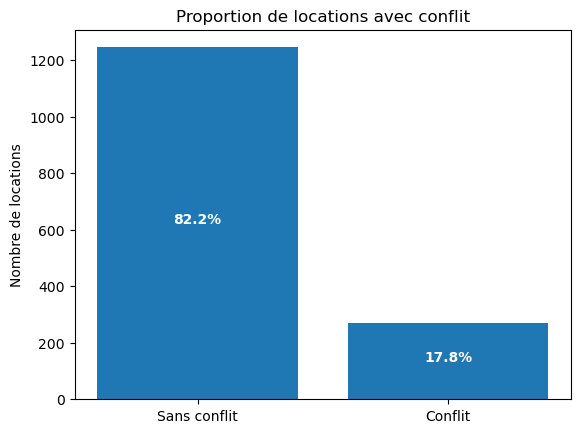

In [49]:
labels = ["Sans conflit", "Conflit"]
values = [1515 - 270, 270]

plt.bar(labels, values)
plt.title("Proportion de locations avec conflit")
plt.ylabel("Nombre de locations")
plt.text(
    0,
    values[0] / 2,
    f"{100*(1-270/1515):.1f}%",
    ha="center",
    color="white",
    weight="bold"
)
plt.text(
    1,
    values[1] / 2,
    f"{100*(270/1515):.1f}%",
    ha="center",
    color="white",
    weight="bold"
)
plt.show()

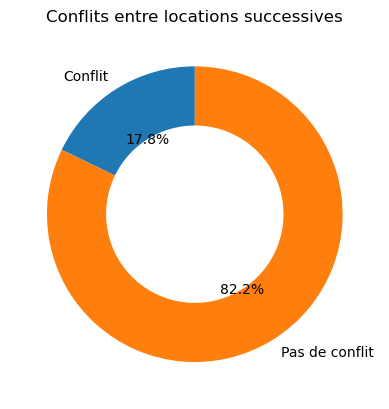

In [51]:
values = [270, 1515 - 270]
labels = ["Conflit", "Pas de conflit"]

fig, ax = plt.subplots()

ax.pie(
    values, 
    labels=labels, 
    autopct="%1.1f%%", 
    startangle=90, 
    wedgeprops={"width": 0.4}
)

ax.set_title("Conflits entre locations successives")
plt.show()

In [52]:
# Buffer analysis : estimate how many rentals would be blocked if we enforced a minimum gap
buffers = [30, 60, 90, 120, 180]
results = []

for b in buffers:
    # Rentals whose gap to previous rental is below the buffer
    blocked = comparables[comparables["time_delta_with_previous_rental_in_minutes"] < b]
    results.append((b, len(blocked)))

# Tabular view
df_buffer = pd.DataFrame(
    results, columns=["Buffer (min)", "Locations bloquées"]
).assign(
    **{
        # Share relative to the comparable base
        "Part des comparables (%)": lambda d: (
            (d["Locations bloquées"] / total_comparables * 100).round(1)
            if total_comparables
            else 0
        )
    }
)
display(df_buffer)

,Buffer (min),Locations bloquées,Part des comparables (%)
0,30,227,15.0
1,60,335,22.1
2,90,480,31.7
3,120,553,36.5
4,180,728,48.1




<div style="font-size:0.85em">

#### Impact de buffers sur les locations
Le tableau montre l'effet de l'introduction d'un temps tampon (buffer) entre deux locations successives. Parmi les locations comparables (celles pour lequel le délai entre locations est connu), un tampon de 30 minutes bloquerait environ 15 % des locations, tandis qu'un tampon de 3 heures en bloquerait près de la moitié (48,1 %).  
Ces résultats illustrent le compromis à trouver entre la réduction du risque de conflits et la disponibilité des véhicules pour de nouvelles locations.
</div>


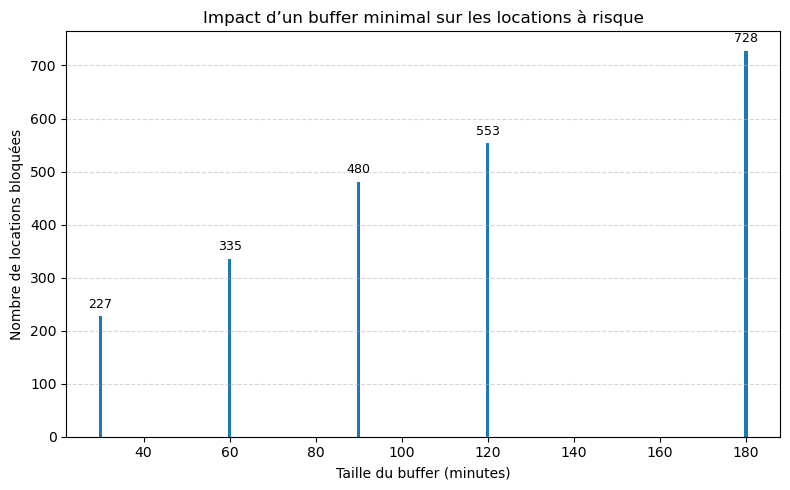


Top 5 conflits (retard le plus > délai disponible) :


,rental_id,car_id,checkin_type,state,time_delta_with_previous_rental_in_minutes,delay_at_checkout_in_minutes,surplus
11622,540063,408117,mobile,ended,90.0,9787.0,9697.0
10900,545582,382060,mobile,ended,660.0,6606.0,5946.0
16744,564327,412869,mobile,ended,90.0,3098.0,3008.0
9003,550036,396532,mobile,ended,0.0,2943.0,2943.0
15168,544056,289570,mobile,ended,30.0,2725.0,2695.0


In [53]:
# Bar plot of the buffer impact
plt.figure(figsize=(8, 5))
plt.bar(df_buffer["Buffer (min)"], df_buffer["Locations bloquées"])
plt.xlabel("Taille du buffer (minutes)")
plt.ylabel("Nombre de locations bloquées")
plt.title("Impact d’un buffer minimal sur les locations à risque")
plt.grid(axis="y", linestyle="--", alpha=0.5)

offset = max(df_buffer["Locations bloquées"]) * 0.015
for x, y in zip(df_buffer["Buffer (min)"], df_buffer["Locations bloquées"]):
    plt.text(
        x,
        y + offset,
        f"{y}",
        ha="center",
        va="bottom",
        fontsize=9
    )
plt.tight_layout()
plt.show()

cols = [
    "rental_id",
    "car_id",
    "checkin_type",
    "state",
    "time_delta_with_previous_rental_in_minutes",
    "delay_at_checkout_in_minutes"
]

print("\nTop 5 conflits (retard le plus > délai disponible) :")
top_conflicts = conflicts.assign(
    surplus=lambda d: d["delay_at_checkout_in_minutes"]
    - d["time_delta_with_previous_rental_in_minutes"]
).sort_values("surplus", ascending=False)

display(top_conflicts[cols + ["surplus"]].head(5))

In [56]:
# Select relevant columns from previous rental
prev_cols = ["rental_id", "car_id", "state", "delay_at_checkout_in_minutes"]
df_small = df[prev_cols].copy()

# Link each rental to its previous one
df_chain = df.merge(
    df_small,
    how="left",
    left_on="previous_ended_rental_id", 
    right_on="rental_id",
    suffixes=("", "_prev")
)

# Canceled rentals potentially linked to a delayed previous rental
conflict_chains = df_chain[
    (df_chain["state"] == "canceled")  
    & (df_chain["state_prev"] == "ended")  
    & (df_chain["delay_at_checkout_in_minutes_prev"] > 0)  
]

print(
    f"Nombre d’annulations potentiellement causées par un retard précédent : {len(conflict_chains)}"
)

display(
    conflict_chains[
        [
            "rental_id",
            "car_id",
            "state",
            "previous_ended_rental_id",
            "state_prev",
            "delay_at_checkout_in_minutes_prev"
        ]
    ].head(10)
)

Nombre d’annulations potentiellement causées par un retard précédent : 106


,rental_id,car_id,state,previous_ended_rental_id,state_prev,delay_at_checkout_in_minutes_prev
204,543768,374169,canceled,543010.0,ended,42.0
1106,538906,334190,canceled,556215.0,ended,77.0
1491,533570,271621,canceled,561375.0,ended,25.0
1527,536722,387431,canceled,536764.0,ended,58.0
1626,539151,282893,canceled,548646.0,ended,201.0
2039,553139,297851,canceled,547650.0,ended,410.0
2181,559037,349171,canceled,552392.0,ended,46.0
2393,543745,359045,canceled,521852.0,ended,650.0
2640,538224,340014,canceled,534999.0,ended,346.0
2714,551372,261576,canceled,547240.0,ended,550.0


Nombre d’annulations potentiellement causées par un retard précédent : 229


,rental_id,car_id,state,previous_ended_rental_id,state_prev,delay_prev,time_delta_with_previous_rental_in_minutes
204,543768,374169,canceled,543010.0,ended,42.0,210.0
242,546160,352528,canceled,546578.0,ended,-536.0,630.0
504,564627,341431,canceled,552005.0,ended,-88.0,150.0
637,568657,317378,canceled,566412.0,ended,-129.0,210.0
669,516550,377700,canceled,545076.0,ended,-35.0,720.0
1002,528088,383110,canceled,546057.0,ended,-86.0,150.0
1106,538906,334190,canceled,556215.0,ended,77.0,630.0
1157,542320,377924,canceled,541053.0,ended,-126.0,120.0
1326,539915,314455,canceled,533006.0,ended,NaN,180.0
1491,533570,271621,canceled,561375.0,ended,25.0,120.0


C:\Users\Floriane\AppData\Local\Temp\ipykernel_14100\700137465.py:63: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



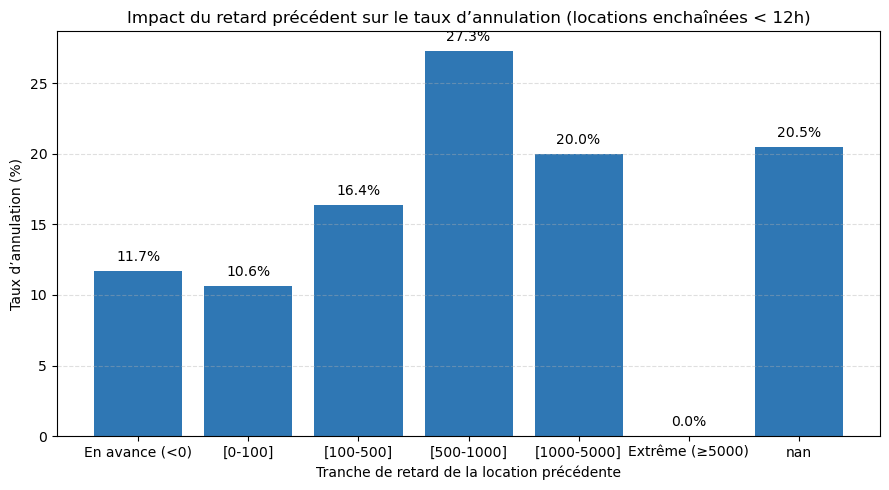

,prev_delay_bucket,total,canceled,taux_annulation_pct
0,En avance (<0),856,100,11.7
1,[0-100],680,72,10.6
2,[100-500],165,27,16.4
3,[500-1000],22,6,27.3
4,[1000-5000],5,1,20.0
5,Extrême (≥5000),1,0,0.0
6,NaN,112,23,20.5


In [59]:
# Bring previous rental info (state & delay) next to the current rental
prev = df[prev_cols].rename(
    columns={
        "rental_id": "prev_rental_id",
        "car_id": "car_id_prev",
        "state": "state_prev",
        "delay_at_checkout_in_minutes": "delay_prev"
    }
)

# Join current rentals with their previous rental (when available)
merged = df.merge(
    prev,
    left_on="previous_ended_rental_id",
    right_on="prev_rental_id",
    how="left",
    validate="m:1"
)

# Keep only valid chained rentals (same car, previous ended, time gap available)
valid = merged[
    merged["previous_ended_rental_id"].notna()
    & (merged["car_id"] == merged["car_id_prev"])
    & (merged["state_prev"] == "ended")
    & (merged["time_delta_with_previous_rental_in_minutes"].notna())
].copy()

# Potential cancellations in chained rentals 
potential_cancels = valid[valid["state"] == "canceled"].copy()

print(
    f"Nombre d’annulations potentiellement causées par un retard précédent : "
    f"{len(potential_cancels)}"
)
display(
    potential_cancels[
        [
            "rental_id",
            "car_id",
            "state",
            "previous_ended_rental_id",
            "state_prev",
            "delay_prev",
            "time_delta_with_previous_rental_in_minutes"
        ]
    ].head(10)
)

# Bucket previous rental delays (chained rentals only)
bins = [-np.inf, 0, 100, 500, 1000, 5000, np.inf]
labels = [
    "En avance (<0)",
    "[0-100]",
    "[100-500]",
    "[500-1000]",
    "[1000-5000]",
    "Extrême (≥5000)"
]
valid["prev_delay_bucket"] = pd.cut(valid["delay_prev"], bins=bins, labels=labels)

# Cancellation rate by previous delay bucket
agg = (
    valid.groupby("prev_delay_bucket", dropna=False)
    .agg(
        total=("rental_id", "size"),
        canceled=("state", lambda s: (s == "canceled").sum())
    )
    .reset_index()
)
agg["taux_annulation_pct"] = (agg["canceled"] / agg["total"] * 100).round(1)

# Bar plot: cancellation rate by previous delay bucket
plt.figure(figsize=(9, 5))
plt.bar(
    agg["prev_delay_bucket"].astype(str), agg["taux_annulation_pct"], color="#2f77b4"
)
for i, v in enumerate(agg["taux_annulation_pct"]):
    plt.text(i, v + 0.5, f"{v:.1f}%", ha="center", va="bottom", fontsize=10)

plt.title(
    "Impact du retard précédent sur le taux d’annulation (locations enchaînées < 12h)",
    loc="center"
)
plt.xlabel("Tranche de retard de la location précédente")
plt.ylabel("Taux d’annulation (%)")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

display(agg)

In [60]:
# Prepare bar labels :"27.3%  (6 / 22)"
agg["label_txt"] = agg.apply(
    lambda r: f"{r['taux_annulation_pct']:.1f}% ({int(r['canceled'])} / {int(r['total'])})",
    axis=1
)

# Bar chart: cancellation rate by previous delay bucket
fig = px.bar(
    agg,
    x="prev_delay_bucket",
    y="taux_annulation_pct",
    text="label_txt",
    title="Impact du retard précédent sur le taux d’annulation<br><sup>Locations enchaînées (&lt;12h)</sup>",
    labels={
        "prev_delay_bucket": "Tranche de retard de la location précédente",
        "taux_annulation_pct": "Taux d’annulation (%)"
    },
    color_discrete_sequence=["#FFA500"],
)

# Place labels outside bars
fig.update_traces(
    textposition="outside",
    cliponaxis=False
)

# Layout
fig.update_layout(
    yaxis=dict(
        gridcolor="rgba(0,0,0,0.1)",
        range=[0, max(agg["taux_annulation_pct"]) + 8]
    ),
    plot_bgcolor="white",
    margin=dict(l=40, r=40, t=70, b=40),
    title_x=0.5,
    font=dict(size=14)
)

fig.show()

In [61]:
# Prepare data for a 100% stacked bar chart
stack = agg.copy()
stack["non_canceled"] = stack["total"] - stack["canceled"]

# Long format: canceled vs non-canceled per delay bucket
stack_long = pd.melt(
    stack,
    id_vars="prev_delay_bucket",
    value_vars=["canceled", "non_canceled"],
    var_name="issue",
    value_name="count"
)

# Percentages within each delay bucket
stack_long = stack_long.merge(
    stack[["prev_delay_bucket", "total"]],
    on="prev_delay_bucket",
    how="left"
)
stack_long["pct"] = (
    stack_long["count"] / stack_long["total"].replace(0, np.nan) * 100
).round(1)

# Human-readable legend labels
issue_map = {"canceled": "Annulée", "non_canceled": "Non annulée"}
stack_long["issue_label"] = stack_long["issue"].map(issue_map)

# Color palette: orange = canceled, blue = non-canceled
color_map = {"Annulée": "#FFA500", "Non annulée": "#1f77b4"}

# 100% stacked bar chart
fig2 = px.bar(
    stack_long,
    x="prev_delay_bucket",
    y="pct",
    color="issue_label",
    color_discrete_map=color_map,
    title="Taux d’annulation selon le retard précédent<br><sup>Locations enchaînées (&lt;12h)</sup>",
    labels={
        "prev_delay_bucket": "Tranche de retard de la location précédente",
        "pct": "Pourcentage (%)",
        "issue_label": "",
    },
    text="pct"
)

fig2.update_traces(texttemplate="%{text:.1f}%", textposition="inside")

fig2.update_layout(
    barmode="stack",
    yaxis=dict(range=[0, 100], gridcolor="rgba(0,0,0,0.1)"),
    plot_bgcolor="white",
    margin=dict(l=40, r=20, t=60, b=40)
)

fig2.show()


<div style="font-size:0.85em;">

- Le graphique montre que les locations enchaînées précédées d’un retard modéré à élevé (entre 100 et 1000 minutes) présentent un taux d’annulation plus important que celles précédées d’un retard faible ou nul.   
- Le risque d’annulation atteint un maximum dans la tranche [500–1000] minutes.
- Les tranches de retard très extrêmes (≥5000 minutes) doivent être interprétées avec prudence, car elles reposent sur un nombre limité d’observations et ne permettent pas de tirer une conclusion robuste.
</div>